In [1]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, time, random, pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
np.random.seed(42);  tf.random.set_seed(42);  random.seed(42)

In [3]:
def generate_series(n_samples=4000, in_len=10, out_len=10):
    X, Y = [], []
    for _ in range(n_samples):
        phase = np.random.rand()*2*np.pi
        freq  = 0.1 + np.random.rand()*0.4
        t     = np.arange(in_len+out_len)
        seq   = np.sin(freq*t + phase) + 0.05*np.random.randn(in_len+out_len)
        X.append(seq[:in_len][:, None])   
        Y.append(seq[in_len:][:, None])  
    return np.array(X).astype("float32"), np.array(Y).astype("float32")

In [4]:
X, Y = generate_series()

X_train, Y_train = X[:3000], Y[:3000]
X_val  , Y_val   = X[3000:3500], Y[3000:3500]
X_test , Y_test  = X[3500:], Y[3500:]
print(X_train.shape, Y_train.shape)

(3000, 10, 1) (3000, 10, 1)


In [5]:
def build_seq2seq(cell_type="RNN", units=64, in_len=10, out_len=10, feat=1):
    encoder_inputs = layers.Input(shape=(in_len, feat))
    if cell_type == "LSTM":
        enc_out, h, c = layers.LSTM(units, return_state=True)(encoder_inputs)
        encoder_state = [h, c]
    elif cell_type == "GRU":
        enc_out, h = layers.GRU(units, return_state=True)(encoder_inputs)
        encoder_state = [h]
    else:  
        enc_out, h = layers.SimpleRNN(units, return_state=True)(encoder_inputs)
        encoder_state = [h]

    decoder_inputs = layers.RepeatVector(out_len)(enc_out)
    if cell_type == "LSTM":
        decoder = layers.LSTM(units, return_sequences=True)
    elif cell_type == "GRU":
        decoder = layers.GRU(units, return_sequences=True)
    else:
        decoder = layers.SimpleRNN(units, return_sequences=True)

    decoder_outputs = decoder(decoder_inputs, initial_state=encoder_state)
    outputs = layers.TimeDistributed(layers.Dense(1))(decoder_outputs)
    model = models.Model(encoder_inputs, outputs, name=f"seq2seq_{cell_type}")
    model.compile(optimizer="adam", loss="mse")
    return model

In [6]:
results = {}
for cell in ["RNN", "LSTM", "GRU"]:
    print(f"\nTraining {cell} model")
    model = build_seq2seq(cell_type=cell)
    es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    t0 = time.time()
    hist = model.fit(X_train, Y_train,
                     validation_data=(X_val, Y_val),
                     epochs=60, batch_size=64, callbacks=[es], verbose=0)
    sec = time.time() - t0
    val_mse = model.evaluate(X_val, Y_val, verbose=0)
    test_mse = model.evaluate(X_test, Y_test, verbose=0)
    results[cell] = {"hist": hist, "sec": sec, "val": val_mse, "test": test_mse, "model": model}
    print(f"{cell:<4} - val MSE: {val_mse:.4f} - test MSE: {test_mse:.4f} - time: {sec:.1f}s")


Training RNN model
RNN  - val MSE: 0.0133 - test MSE: 0.0157 - time: 213.7s

Training LSTM model
LSTM - val MSE: 0.0103 - test MSE: 0.0130 - time: 375.2s

Training GRU model
GRU  - val MSE: 0.0106 - test MSE: 0.0129 - time: 330.4s


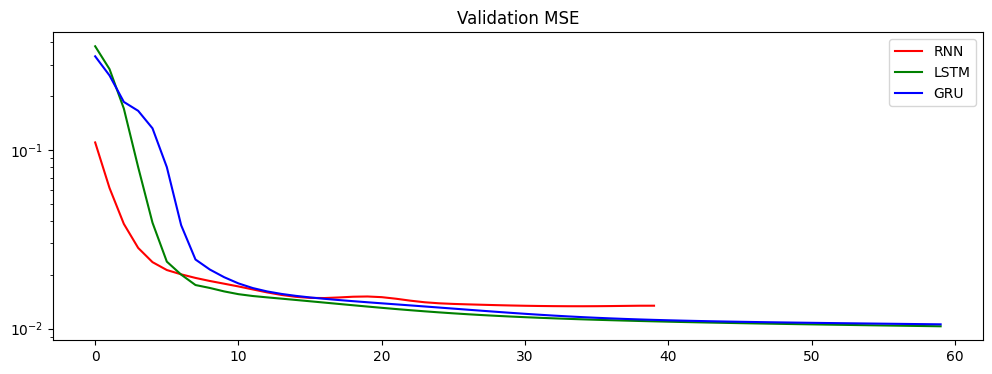

In [7]:
plt.figure(figsize=(12,4))
for cell, col in zip(results.keys(), ["r", "g", "b"]):
    plt.plot(results[cell]["hist"].history["val_loss"], label=f"{cell}", color=col)
plt.title("Validation MSE")
plt.yscale("log")
plt.legend()
plt.show()

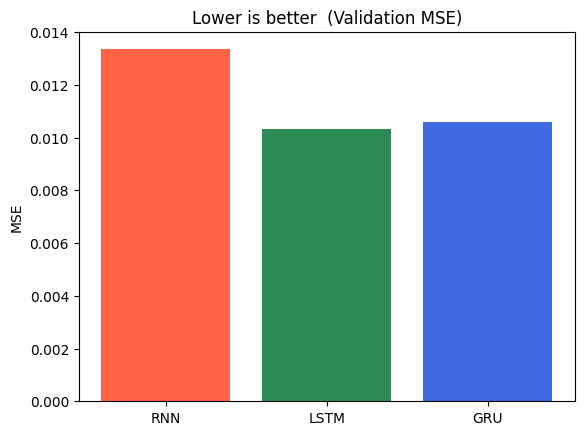

In [8]:
cells, vals = zip(*[(c, results[c]["val"]) for c in results])
plt.bar(cells, vals, color=["tomato","seagreen","royalblue"])
plt.title("Lower is better  (Validation MSE)")
plt.ylabel("MSE")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


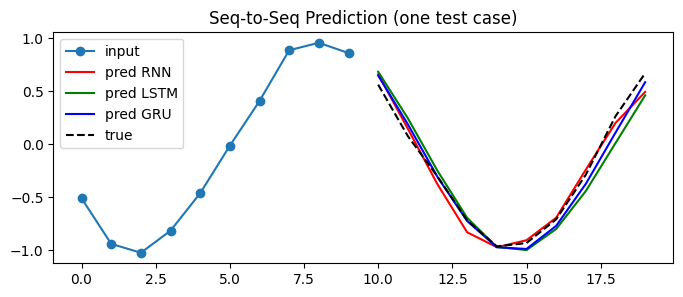

In [9]:
k = 3 
plt.figure(figsize=(8,3))
plt.plot(range(10), X_test[k,:,0], label="input", marker='o')
for cell, col in zip(results.keys(), ["r","g","b"]):
    pred = results[cell]["model"].predict(X_test[k:k+1])[0,:,0]
    plt.plot(range(10,20), pred, label=f"pred {cell}", color=col)
plt.plot(range(10,20), Y_test[k,:,0], label="true", color="k", linestyle="--")
plt.legend()
plt.title("Seq‑to‑Seq Prediction (one test case)")
plt.show()

In [10]:
df = pd.DataFrame({c:{"Val MSE":results[c]["val"],
                      "Test MSE":results[c]["test"],
                      "Train time (s)":results[c]["sec"]} for c in results}).T
display(df)

,Val MSE,Test MSE,Train time (s)
RNN,0.013345,0.015662,213.697196
LSTM,0.010308,0.013004,375.245069
GRU,0.010570,0.012905,330.428252
